In [ ]:
!pip install pulp
!apt-get install -y -qq glpk-utils

In [ ]:
!which glpsol

/usr/bin/glpsol


In [ ]:
!pulptest

Available solvers: ['GLPK_CMD', 'PULP_CBC_CMD']
Unavailable solvers: {'FSCIP_CMD', 'MIPCL_CMD', 'COPT_DLL', 'PYGLPK', 'CHOCO_CMD', 'COIN_CMD', 'XPRESS_PY', 'CPLEX_CMD', 'MOSEK', 'COPT_CMD', 'HiGHS_CMD', 'XPRESS', 'COINMP_DLL', 'SCIP_PY', 'SCIP_CMD', 'CPLEX_PY', 'HiGHS', 'GUROBI_CMD', 'COPT', 'GUROBI'}
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss..............................................GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /tmp/47cdf9b36b644f9192d8a85bffaebfee-pulp.lp -o /tmp/47cdf9b36b644f9192d8a85bffaebfee-pulp.sol
Reading problem data fr

In [1]:
# %%
# 1. Initialization
# ===========================

import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go

# Working directory
#datadir = "/content/"
datadir = "/Users/ruivieira/Documents/Ecole/6_ZHAW/VT1/vt1-energy-investment-model/data/"
print("Default GLPK path:", pulp.GLPK().path)
solver_list = pulp.listSolvers()
print(solver_list)



Default GLPK path: glpsol
['GLPK_CMD', 'PYGLPK', 'CPLEX_CMD', 'CPLEX_PY', 'GUROBI', 'GUROBI_CMD', 'MOSEK', 'XPRESS', 'XPRESS', 'XPRESS_PY', 'PULP_CBC_CMD', 'COIN_CMD', 'COINMP_DLL', 'CHOCO_CMD', 'MIPCL_CMD', 'SCIP_CMD', 'FSCIP_CMD', 'SCIP_PY', 'HiGHS', 'HiGHS_CMD', 'COPT', 'COPT_DLL', 'COPT_CMD']


In [26]:

# %%
# 2. Data
# ===========================

demand_data = pd.read_csv(
    datadir + 'raw/data-load-becc.csv',
    # datadir+'data-load-becc.csv',
    delimiter=';',
    names=['time', 'load'],  # Specify the column names
    parse_dates=['time'],
    dayfirst=True,
    header=0
)
demand_data['load'] = pd.to_numeric(demand_data['load']) * 100

wind_data = pd.read_csv(datadir + 'raw/wind-sion-2023.csv', skiprows=3, parse_dates=['time'], delimiter=',')

# Load into DataFrames
wind_gen = pd.DataFrame({
    'time': wind_data['time'],
    'id': 1,  # Assuming wind generator has ID 1
    'bus': 1,  # Assuming wind generator is connected to bus 1
    'pmax': wind_data['electricity'],  # Time-varying maximum generation
    'pmin': 0,  # Assuming minimum generation is 0
    'gencost': 5  # Cost coefficient for wind generator
})
gas_gen = pd.DataFrame({
    'time': pd.to_datetime(wind_data['time']),  # Ensure the time column matches
    'id': 2,  # Assuming gas generator has ID 2
    'bus': 2,  # Assuming gas generator is connected to bus 2
    'pmax': 250,  # Constant maximum generation
    'pmin': 0,
    'gencost': 80  # Cost coefficient for gas generator
})

storage_id = 3  # Unique ID for storage
storage_bus = 3  # Bus to which storage is connected
P_max_storage = 40  # Maximum charging/discharging power in MW
storage_cost = 0  # Cost coefficient for storage (adjust as needed)

# Create storage generator DataFrame
storage_gen = pd.DataFrame({
    'time': pd.to_datetime(wind_data['time']),  # Assuming 'time' column exists
    'id': storage_id,
    'bus': storage_bus,
    'pmax': P_max_storage,
    'pmin': -P_max_storage,
    'gencost': storage_cost
})
# Combine generator data
gen_time_series = pd.concat([wind_gen, gas_gen, storage_gen], ignore_index=True)

# Create a DataFrame for time-varying demand at bus 4
demand_time_series = pd.DataFrame({
    'time': demand_data['time'],
    'bus': 4,  # Demand is at bus 4
    'pd': demand_data['load'],
})

# Ensure 'time' column is datetime
demand_time_series['time'] = pd.to_datetime(demand_time_series['time'])

# Load branch and bus data
branch = pd.read_csv(datadir + "processed/branch.csv")
bus = pd.read_csv(datadir + "processed/bus.csv")

# Rename all columns to lowercase
for df in [branch, bus]:
    df.columns = df.columns.str.lower()

# Create generator and line IDs
branch['id'] = np.arange(1, len(branch) + 1)

# Susceptance of each line based on reactance
# Assuming reactance >> resistance, susceptance ≈ 1 / reactance
branch['sus'] = 1 / branch['x']

# Display the bus DataFrame as an example
print(bus)
# print(gen_time_series)
print(branch)

/var/folders/qq/3r2g7xt92ms9t56j1h78zq0c0000gn/T/ipykernel_21825/4268278715.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demand_data = pd.read_csv(


   bus_i  type   pd     qd  gs  bs  area  vm  va  basekv  zone  vmax  vmin
0      1     2    0   0.00   0   0     1   1   0     230     1   1.1   0.9
1      2     2    0   0.00   0   0     1   1   0     230     1   1.1   0.9
2      3     1  100  98.61   0   0     1   1   0     230     1   1.1   0.9
3      4     1    0   0.00   0   0     1   1   0     230     1   1.1   0.9
   fbus  tbus        r       x        b  ratea  rateb  ratec  ratio  angle  \
0     1     3  0.00281  0.0281  0.00712     60     60     60      0      0   
1     1     2  0.00281  0.0281  0.00712     60     60     60      0      0   
2     2     3  0.00281  0.0281  0.00712     60     60     60      0      0   
3     3     4  0.00281  0.0281  0.00712     60     60     60      0      0   
4     2     4  0.00281  0.0281  0.00712     60     60     60      0      0   
5     1     4  0.00281  0.0281  0.00712     60     60     60      0      0   

   status  angmin  angmax  id        sus  
0       1    -360     360   1  35.5

## Function 

Parameters:
- gen_time_series (pd.DataFrame): Generator data with time series.
- branch (pd.DataFrame): Branch data.
- bus (pd.DataFrame): Bus data.
- demand_time_series (pd.DataFrame): Demand data with time series.
- eta (float): Storage efficiency (0 < eta <= 1).
- E_max (float): Maximum energy storage capacity (MWh).
- P_max (float): Maximum charging/discharging power (MW).
- time_steps (list of pd.Timestamp): List of time steps to consider.
- E_initial (float, optional): Initial energy in the storage (MWh).
- delta_t (float): Duration of each time step in hours.


In [27]:
def dcopf_with_storage(gen_time_series, branch, bus, demand_time_series, eta, E_max, P_max, time_steps, E_initial=None, delta_t=1):

    # Create the optimization model
    DCOPF = pulp.LpProblem("DCOPF_With_Storage", pulp.LpMinimize)

    # Define sets
    storage_id = 3  # Assuming storage has ID 3; adjust as necessary
    G = [g for g in gen_time_series['id'].unique() if g != storage_id]  # Set of generators excluding storage
    N = bus['bus_i'].values            # Set of buses
    T = time_steps                     # Original time steps
 
    # Extend time steps by one to compute one more value
    from pandas.tseries.offsets import DateOffset
    next_time = T[-1] + DateOffset(hours=delta_t)
    extended_T = T + [next_time]

    # Identify Storage Parameters
    storage_generators = gen_time_series[gen_time_series['id'] == storage_id]
    if storage_generators.empty:
        print(f"Error: Storage generator with id {storage_id} not found in gen_time_series.")
        return None
    else:
        storage_bus = storage_generators['bus'].iloc[0]

    # Initialize Variables
    # Generation Variables: P_g^t for each generator g at each time t
    GEN = {}
    for g in G:
        for t in T:
            gen_row = gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t)]
            if gen_row.empty:
                print(f"Error: Generator {g} has no data for time {t}.")
                return None
            pmin = gen_row['pmin'].values[0]
            pmax = gen_row['pmax'].values[0]
            GEN[g, t] = pulp.LpVariable(f"GEN_{g}_{t}_var", lowBound=pmin, upBound=pmax)

    # Voltage Angle Variables: theta_i^t for each bus i at each time t
    THETA = {(i, t): pulp.LpVariable(f"THETA_{i}_{t}_var", lowBound=None) for i in N for t in T}

    # Flow Variables: F_ij^t for each branch (i,j) at each time t
    FLOW = {}
    for idx, row in branch.iterrows():
        i = row['fbus']
        j = row['tbus']
        for t in T:
            FLOW[i, j, t] = pulp.LpVariable(f"FLOW_{i}_{j}_{t}_var", lowBound=None)

    # Storage Variables for time steps in T
    P_charge = {t: pulp.LpVariable(f"P_charge_{t}_var", lowBound=0, upBound=P_max) for t in T}
    P_discharge = {t: pulp.LpVariable(f"P_discharge_{t}_var", lowBound=0, upBound=P_max) for t in T}
    E = {t: pulp.LpVariable(f"E_{t}_var", lowBound=0, upBound=E_max) for t in extended_T} # in extended_T (dynamic)

    # Set Slack Bus Angle to 0 for all time steps
    for t in T:
        DCOPF += THETA[1, t] == 0, f"Slack_Bus_Angle_Time_{t}_constraint"

    # Objective Function: Minimize Total Generation Cost
    DCOPF += pulp.lpSum(
        gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'gencost'].values[0] * GEN[g, t]
        for g in G for t in T
    ), "Total_Generation_Cost"

    # Set initial SoC
    if E_initial is not None:
        DCOPF += E[T[0]] == E_initial, "Initial_Storage_SoC"
    else:
        DCOPF += E[T[0]] == 0, "Initial_Storage_SoC"

    # Storage Dynamics over extended_T (Corrected)
    for idx, t in enumerate(T):
        next_t = extended_T[idx + 1]
        DCOPF += E[next_t] == E[t] + eta * P_charge[t] * delta_t - (1/eta) * P_discharge[t] * delta_t, f"Storage_Dynamics_Time_{t}_constraint"

    # Final SoC Constraint
    if E_initial is not None:
        DCOPF += E[extended_T[-1]] == E_initial, "Final_Storage_SoC"
    else:
        DCOPF += E[extended_T[-1]] == 0, "Final_Storage_SoC"

    # Power Balance at Each Bus for each t in T (Corrected storage bus part)
    for t in T:
        for i in N:
            # Sum of generation at bus i
            gen_sum = pulp.lpSum(GEN[g, t] for g in G if gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'bus'].values[0] == i)

            # Demand at bus i
            demand = demand_time_series.loc[(demand_time_series['bus'] == i) & (demand_time_series['time'] == t), 'pd']
            demand_value = demand.values[0] if not demand.empty else 0

            # If this bus has storage, include storage power with efficiency
            if i == storage_bus:
                gen_sum += P_discharge[t] - P_charge[t]  # Net power from storage 

            # Net flow out of bus i
            flow_out = pulp.lpSum(FLOW[i, j, t] for j in branch.loc[branch['fbus'] == i, 'tbus'])

            # Net flow into bus i
            flow_in = pulp.lpSum(FLOW[j, i, t] for j in branch.loc[branch['tbus'] == i, 'fbus'])

            # Power balance constraint
            DCOPF += gen_sum - demand_value + flow_in - flow_out == 0, f"Power_Balance_Bus_{i}_Time_{t}_constraint"

    # DC Power Flow Constraints
    for idx_branch, row in branch.iterrows():
        i = row['fbus']
        j = row['tbus']
        susceptance = row['sus']
        for t in T:
            DCOPF += FLOW[i, j, t] == susceptance * (THETA[i, t] - THETA[j, t]), f"Flow_Constraint_{i}_{j}_Time_{t}_constraint"

    # Flow Limits
    for idx_branch, row in branch.iterrows():
        i = row['fbus']
        j = row['tbus']
        rate_a = row['ratea']
        for t in T:
            DCOPF += FLOW[i, j, t] <= rate_a, f"Flow_Limit_{i}_{j}_Upper_Time_{t}_constraint"
            DCOPF += FLOW[i, j, t] >= -rate_a, f"Flow_Limit_{i}_{j}_Lower_Time_{t}_constraint"

    # Solve the optimization problem using CBC (or any other solver)
    DCOPF.solve(pulp.PULP_CBC_CMD(msg=True))  # You can replace with GLPK or another solver

    # Check Solver Status
    if pulp.LpStatus[DCOPF.status] != 'Optimal':
        print(f"Optimization did not find an optimal solution. Status: {pulp.LpStatus[DCOPF.status]}")
        return None

    # Extracting Generation Results
    generation = pd.DataFrame([
        {'time': t, 'id': g, 'node': gen_time_series.loc[(gen_time_series['id'] == g) & (gen_time_series['time'] == t), 'bus'].values[0], 'gen': pulp.value(GEN[g, t])}
        for g in G for t in T
    ])

    # Extracting Voltage Angles
    angles = pd.DataFrame([
        {'time': t, 'bus': i, 'theta': pulp.value(THETA[i, t])}
        for i in N for t in T
    ])

    # Extracting Flow Results
    flows = pd.DataFrame([
        {'time': t, 'from_bus': i, 'to_bus': j, 'flow': pulp.value(FLOW[i, j, t])}
        for (i, j, t) in FLOW
    ])

    # Extracting Storage States
    storage = pd.DataFrame([
        {
            'time': t,
            'E': pulp.value(E[t]),
            'P_charge': pulp.value(P_charge[t]) if t in P_charge else None,
            'P_discharge': pulp.value(P_discharge[t]) if t in P_discharge else None
        }
        for t in extended_T
    ])

    # Shift the SoC values back by one time step to align with T
    storage['E'] = storage['E'].shift(-1)
    # Remove the last row which has NaN after shifting
    storage = storage.iloc[:-1]

    # Total Cost
    total_cost = pulp.value(DCOPF.objective)

    # Status
    status = pulp.LpStatus[DCOPF.status]

    # Return the solution as a dictionary
    return {
        'generation': generation,
        'angles': angles,
        'flows': flows,
        'storage': storage,
        'cost': total_cost,
        'status': status
    }


In [31]:
# %%
# 4. Solve with Storage
# ===========================

# Define storage parameters
E_max = 40     # Maximum energy storage capacity in MWh
eta = 0.99     # Storage efficiency
P_max = 40     # Maximum charging/discharging power in MW

# Define the start and end dates for the optimization window
start_date = '2023-03-11'  # Example start date
end_date = '2023-03-15'    # Example end date

# Filter generator data for the selected date range
mask_gen = (gen_time_series['time'] >= pd.to_datetime(start_date)) & (gen_time_series['time'] <= pd.to_datetime(end_date))
gen_time_series_window = gen_time_series.loc[mask_gen].copy()

# Filter demand data for the selected date range
mask_demand = (demand_time_series['time'] >= pd.to_datetime(start_date)) & (demand_time_series['time'] <= pd.to_datetime(end_date))
demand_time_series_window = demand_time_series.loc[mask_demand].copy()

# Extract and sort unique time steps
time_steps = sorted(gen_time_series_window['time'].unique())

# Debugging: Verify Storage Generator Presence
storage_present = gen_time_series_window[gen_time_series_window['id'] == storage_id]
if storage_present.empty:
    print(f"Error: Storage generator with id {storage_id} is not present in gen_time_series_window.")
else:
    pass
    #print(f"Storage generator present:\n{storage_present}")

# Run the DCOPF with Storage
results = dcopf_with_storage(
    gen_time_series=gen_time_series_window,
    branch=branch,
    bus=bus,
    demand_time_series=demand_time_series_window,
    eta=eta,
    E_max=E_max,
    P_max=P_max,
    time_steps=time_steps,
    E_initial=0,
    delta_t=1
)

# Check and Extract Results
if results and results['status'] == 'Optimal':
    print("Optimization was successful.")
    print(f"Total Cost: {results['cost']}")

    # Extract Results
    generation_over_time = results['generation']
    storage_over_time = results['storage']
    flows_over_time = results['flows']

    # Optional: Display the first few rows of each result DataFrame
    print("\nGeneration Over Time:")
    print(generation_over_time.head())

    print("\nStorage States Over Time:")
    print(storage_over_time.head())

    print("\nFlows Over Time:")
    print(flows_over_time.head())
else:
    print("Optimization failed or no optimal solution found.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/qq/3r2g7xt92ms9t56j1h78zq0c0000gn/T/579636e452b942ecaf242f3da125db6b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/qq/3r2g7xt92ms9t56j1h78zq0c0000gn/T/579636e452b942ecaf242f3da125db6b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2335 COLUMNS
At line 7479 RHS
At line 9810 BOUNDS
At line 11267 ENDATA
Problem MODEL has 2330 rows, 1456 columns and 4949 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 776 (-1554) rows, 1066 (-390) columns and 2811 (-2138) elements
Perturbing problem by 0.001% of 80 - largest nonzero change 9.646793e-06 ( 4.5761209e-05%) - largest zero change 9.6338759e-06
0  Obj -0.027154368 Primal inf 67268.9 (679)
90  Obj 0.0028585137 Primal 

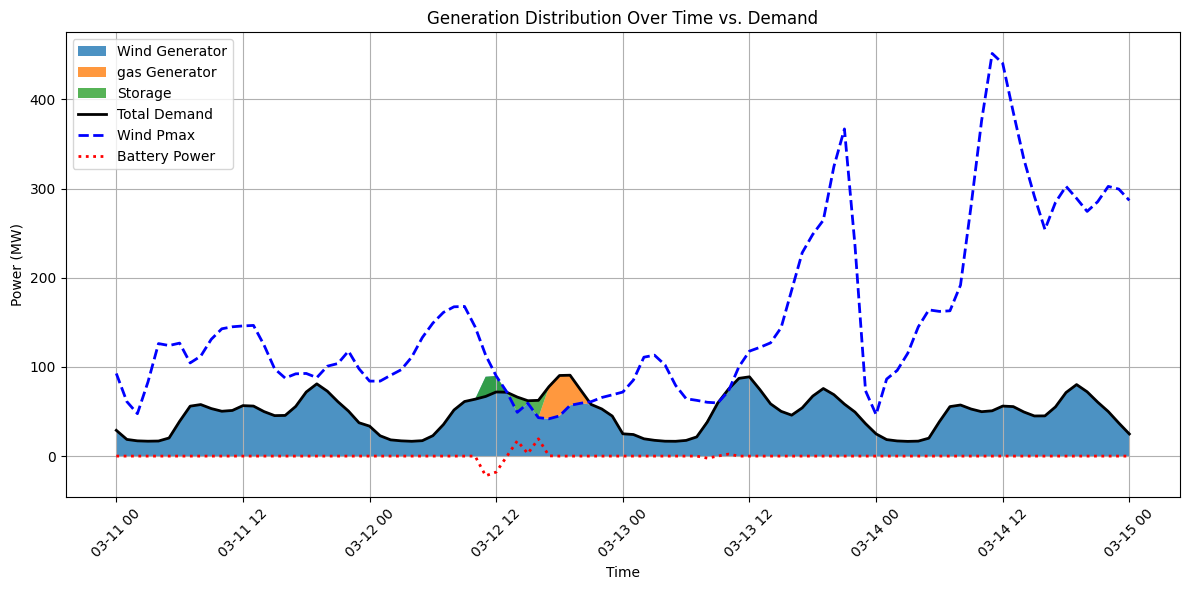

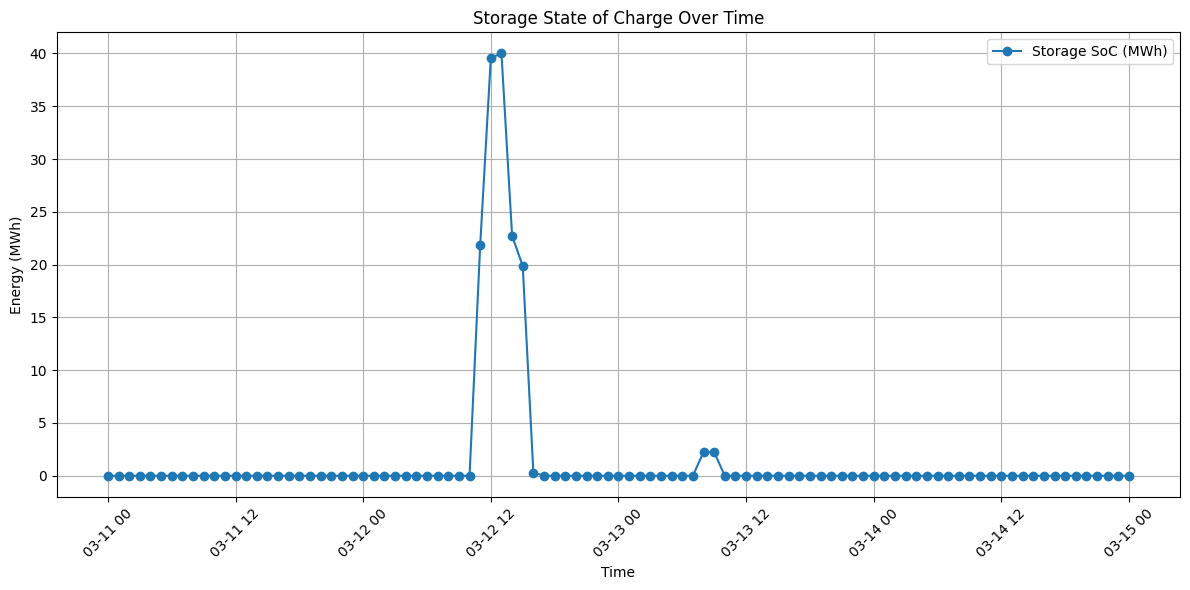

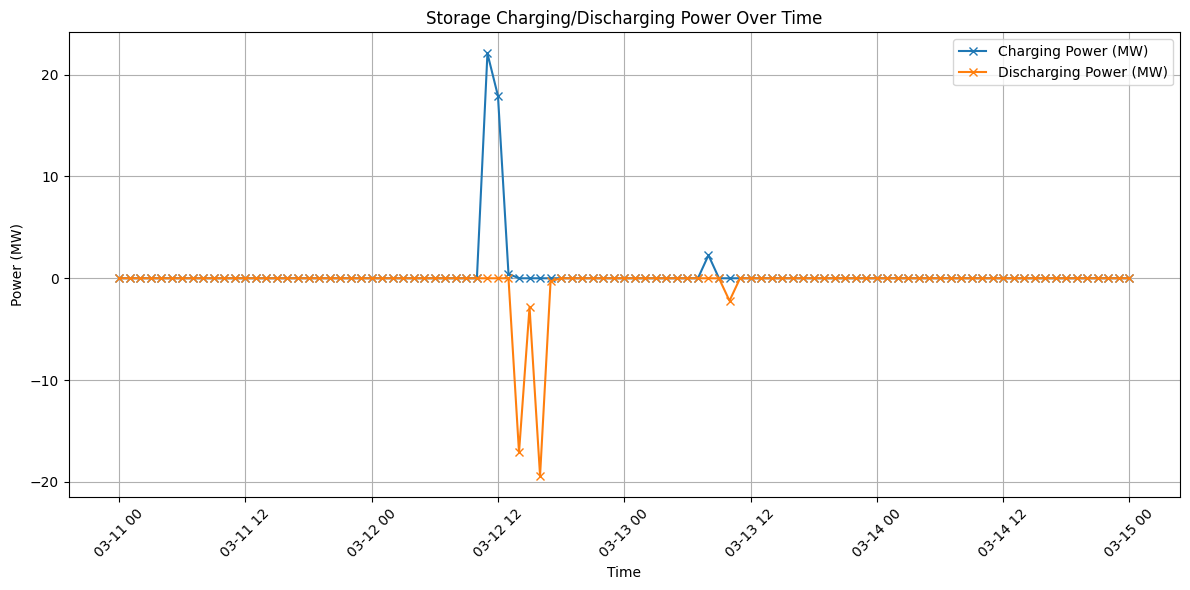

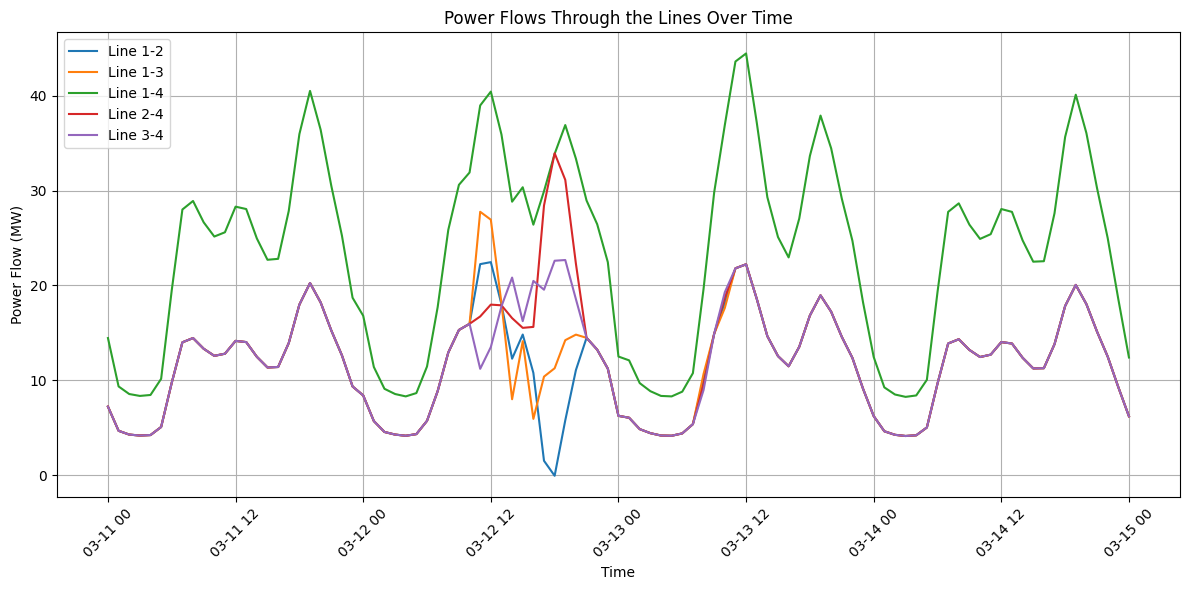

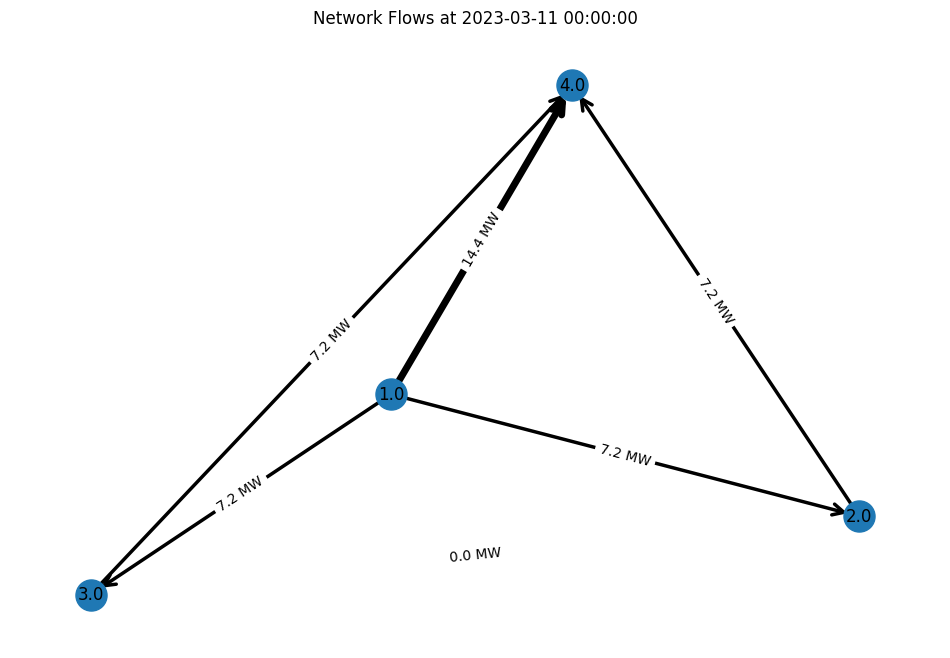

In [32]:
# 5. Visualization
# ===========================

if results and results['status'] == 'Optimal':
    # 1. Pivot the Generation Data
    gen_pivot = generation_over_time.pivot(index='time', columns='id', values='gen')
    gen_pivot = gen_pivot.sort_index()

    # Include storage discharge as generation (negative values when charging)
    storage_power = storage_over_time.set_index('time')
    storage_net_power = storage_power['P_discharge'] - storage_power['P_charge']
    gen_pivot['Storage'] = storage_net_power

    # 2. Prepare the Total Demand Series
    total_demand = demand_time_series_window.set_index('time')['pd'].reindex(gen_pivot.index)

    # Map generator IDs to names (optional)
    gen_pivot.rename(columns={
        1: 'Wind Generator',
        2: 'gas Generator',
    }, inplace=True)

    # Reorder columns for plotting
    gen_pivot = gen_pivot[['Wind Generator', 'gas Generator', 'Storage']]

    # Extract wind_Pmax over time
    wind_pmax = gen_time_series_window[gen_time_series_window['id'] == 1][['time', 'pmax']].drop_duplicates().set_index('time')['pmax']
    wind_pmax = wind_pmax.reindex(gen_pivot.index)

    # Extract battery net power over time
    battery_power = storage_net_power.reindex(gen_pivot.index)

    # Plot the Stacked Area Chart with wind_Pmax and battery power
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot stacked generation
    ax.stackplot(gen_pivot.index, gen_pivot[['Wind Generator', 'gas Generator', 'Storage']].T, labels=gen_pivot.columns, alpha=0.8)
    ax.plot(total_demand.index, total_demand.values, label='Total Demand', color='black', linewidth=2) # Plot total demand
    ax.plot(wind_pmax.index, wind_pmax.values, label='Wind Pmax', color='blue', linestyle='--', linewidth=2) # Plot wind_Pmax
    ax.plot(battery_power.index, battery_power.values, label='Battery Power', color='red', linestyle=':', linewidth=2)# Plot battery power

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Power (MW)')
    ax.set_title('Generation Distribution Over Time vs. Demand')
    ax.legend(loc='upper left' )#,  title='Generators and Additional Data'
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # %%
    # Plot Storage SoC Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(storage_over_time['time'], storage_over_time['E'], label='Storage SoC (MWh)', marker='o')
    plt.xlabel('Time')
    plt.ylabel('Energy (MWh)')
    plt.title('Storage State of Charge Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Storage Charging and Discharging Power Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(storage_over_time['time'], storage_over_time['P_charge'], label='Charging Power (MW)', marker='x')
    plt.plot(storage_over_time['time'], -storage_over_time['P_discharge'], label='Discharging Power (MW)', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Power (MW)')
    plt.title('Storage Charging/Discharging Power Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    # Extract Voltage Angles
    angles_over_time = results['angles']
    angles_over_time = angles_over_time.pivot(index='time', columns='bus', values='theta')
    angles_over_time = angles_over_time.sort_index()

    # Define lines and their susceptances (using bus numbers from 1 to 4)
    lines = [
        {'name': 'Line 1-2', 'from': 1, 'to': 2, 'Y': branch.loc[(branch['fbus'] == 1) & (branch['tbus'] == 2), 'sus'].values[0]},
        {'name': 'Line 1-3', 'from': 1, 'to': 3, 'Y': branch.loc[(branch['fbus'] == 1) & (branch['tbus'] == 3), 'sus'].values[0]},
        {'name': 'Line 1-4', 'from': 1, 'to': 4, 'Y': branch.loc[(branch['fbus'] == 1) & (branch['tbus'] == 4), 'sus'].values[0]},
        {'name': 'Line 2-4', 'from': 2, 'to': 4, 'Y': branch.loc[(branch['fbus'] == 2) & (branch['tbus'] == 4), 'sus'].values[0]},
        {'name': 'Line 3-4', 'from': 3, 'to': 4, 'Y': branch.loc[(branch['fbus'] == 3) & (branch['tbus'] == 4), 'sus'].values[0]},
    ]

    # Initialize a dictionary to store power flows for each line
    power_flows = {line['name']: [] for line in lines}

    # Compute power flows using voltage angles and line susceptances
    for idx, time in enumerate(angles_over_time.index):
        theta = angles_over_time.loc[time].to_dict()  # Voltage angles at the current time
        for line in lines:
            i = line['from']
            j = line['to']
            Y_ij = line['Y']
            flow = Y_ij * (theta[i] - theta[j])
            power_flows[line['name']].append(flow)


    # Plot power flows
    plt.figure(figsize=(12, 6))
    for line in lines:
        plt.plot(angles_over_time.index, power_flows[line['name']], label=line['name'])
    plt.xlabel('Time')
    plt.ylabel('Power Flow (MW)')
    plt.title('Power Flows Through the Lines Over Time')
    # plt.axhline(-branch['ratea'], color='r', linestyle='--', label='Storage Power Limits')
    # plt.axhline(branch['ratea'], color='r', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # %%
    # Visualize Network Flows at a Specific Time
    # Create a graph
    G = nx.DiGraph()

    # Add nodes
    for idx, row in bus.iterrows():
        G.add_node(row['bus_i'])

    # Add edges with attributes
    for idx, row in branch.iterrows():
        G.add_edge(row['fbus'], row['tbus'], capacity=row['ratea'])

    # Choose a specific time to visualize
    time_to_visualize = time_steps[0]  # Change as needed

    # Get flows at that time
    flows_at_time = flows_over_time[flows_over_time['time'] == time_to_visualize]

    # Add flow data to edges
    for idx, row in flows_at_time.iterrows():
        G[row['from_bus']][row['to_bus']]['flow'] = row['flow']

    # Get positions for the nodes (you might need to define these)
    pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for consistent layout

    # Get edge widths based on flow
    edge_flows = [abs(G[u][v]['flow']) for u, v in G.edges()]
    max_flow = max(edge_flows) if edge_flows else 1
    edge_widths = [5 * flow / max_flow for flow in edge_flows]  # Scale widths

    # Plot the network
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos)

    # Draw edges with widths representing flows
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=edge_widths)

    # Add edge labels for flows
    edge_labels = {(u, v): f"{G[u][v]['flow']:.1f} MW" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(f"Network Flows at {time_to_visualize}")
    plt.axis('off')
    plt.show()
else:
    pass
